# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import os
from pprint import pprint
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# A. Load Data (a sample)

In [2]:
def load_and_process_data(path, nrows=1000000, timestamp=False):
    
    # load data
    if timestamp:
        df = pd.read_csv(path, nrows=nrows, parse_dates=['timestamp'])
    else:
        df = pd.read_csv(path, nrows=nrows)
    
    # convert utf-16-like ids to integers
    try:
        df['installation_id'] = df['installation_id'].apply(lambda x: int(x,16))
    except:
        pass

    # convert milliseconds to mins
    try:
        df['game_time'] = df['game_time'].apply(lambda x: round(x/(1000*60),2))
    except:
        pass
    
    # convert string dict representation to dict
    try:
        df['event_data'] = df['event_data'].apply(json.loads)
    except:
        pass
    
    df = df.set_index(['installation_id','game_session'])
    
    return df

### A.1 Train

In [3]:
train = load_and_process_data('./data/train.csv', nrows=1000000, timestamp=True)
train.head()

event_id                        timestamp                                         event_data  event_count  event_code  game_time                          title      type      world
installation_id game_session                                                                                                                                                                                          
125199          45bb1e1b6b50c07b  27253bdc 2019-09-06 17:53:46.937000+00:00             {'event_code': 2000, 'event_count': 1}            1        2000       0.00        Welcome to Lost Lagoon!      Clip       NONE
                17eeb7f223665f53  27253bdc 2019-09-06 17:54:17.519000+00:00             {'event_code': 2000, 'event_count': 1}            1        2000       0.00           Magma Peak - Level 1      Clip  MAGMAPEAK
                0848ef14a8dc6892  77261ab5 2019-09-06 17:54:56.302000+00:00  {'version': '1.0', 'event_count': 1, 'game_tim...            1        2000       0.00  Sandcastle Builder (Activity)  Activity  MAGMAPEAK
                0848ef14a8dc6892  b2dba42b 2019-09-06 17:54:56.387000+00:00  {'description': 'Let's build a sandcastle! Fir...            2        3010       0.00  Sandcastle Builder (Activity)  Activity  MAGMAPEAK
                0848ef14a8dc6892  1bb5fbdb 2019-09-06 17:55:03.253000+00:00  {'description': 'Let's build a sandcastle! Fir...            3        3110       0.12  Sandcastle Builder (Activity)  Activity  MAGMAPEAK

### Remove Noisy Data

Noise: game_time =0  and incorrect 

### A.2 Labels

In [4]:
train_labels = load_and_process_data('./data/train_labels.csv', nrows=1000000)
train_labels.head()

title  num_correct  num_incorrect  accuracy  accuracy_group
installation_id game_session                                                                                        
435871          6bdf9623adc94d89  Mushroom Sorter (Assessment)            1              0       1.0               3
                77b8ee947eb84b4e    Bird Measurer (Assessment)            0             11       0.0               0
                901acc108f55a5a1  Mushroom Sorter (Assessment)            1              0       1.0               3
                9501794defd84e4d  Mushroom Sorter (Assessment)            1              1       0.5               2
                a9ef3ecb3d1acc6a    Bird Measurer (Assessment)            1              0       1.0               3

### A3. Merge all Assessment train data

In [5]:
assessments = pd.merge(train[train.type == 'Assessment'], train_labels, 
                       left_index=True, right_index=True, how='inner')

# clean df
assessments = assessments.drop(['title_y','type'],axis=1)\
                         .rename({'title_x':'title'},axis=1)

In [6]:
assessments.head()

event_id                        timestamp                                         event_data  event_count  event_code  game_time                         title        world  num_correct  num_incorrect  accuracy  accuracy_group
installation_id game_session                                                                                                                                                                                                                                       
435871          6bdf9623adc94d89  3bfd1a65 2019-08-06 05:37:50.020000+00:00  {'version': '1.0', 'event_count': 1, 'game_tim...            1        2000       0.00  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3
                6bdf9623adc94d89  db02c830 2019-08-06 05:37:50.078000+00:00  {'event_count': 2, 'game_time': 77, 'event_cod...            2        2025       0.00  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3
                6bdf9623adc94d89  a1e4395d 2019-08-06 05:37:50.082000+00:00  {'description': 'Pull three mushrooms out of t...            3        3010       0.00  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3
                6bdf9623adc94d89  7da34a02 2019-08-06 05:37:52.799000+00:00  {'coordinates': {'x': 199, 'y': 484, 'stage_wi...            4        4070       0.05  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3
                6bdf9623adc94d89  28ed704e 2019-08-06 05:37:53.631000+00:00  {'height': 1, 'coordinates': {'x': 171, 'y': 5...            5        4025       0.06  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3

# B. Data Exploration/Visualization

## B1. Bad data

Observe that the accuracy (or equivalently the num_correct) is the same for all events generated in the same assessmnet session:

In [7]:
temp_df = assessments.groupby(['installation_id','game_session'])[['event_count','accuracy']]\
                     .agg({'event_count':'count', 'accuracy':'sum'})
temp_df.head()


event_count  accuracy
installation_id game_session                           
435871          6bdf9623adc94d89           35      35.0
                77b8ee947eb84b4e           87       0.0
                901acc108f55a5a1           48      48.0
                9501794defd84e4d           42      21.0
                a9ef3ecb3d1acc6a           32      32.0

Observe that there are no assessment sessions with event_count=1:

In [8]:
np.sum(temp_df.event_count[temp_df.event_count==1])

0

On the other hand, the whole ```train``` dataset has a lot of sessions with event_count=1:

In [9]:
print('Fraction of single-event sessions in train: {0}/{1} = {2}%'\
      .format(
              np.sum(train.event_count[train.event_count==1]),
              len(train),
              round(np.sum(train.event_count[train.event_count==1])/len(train)*100,2)
             )
     )

Fraction of single-event sessions in train: 28338/1000000 = 2.83%


In [10]:
del temp_df

Note: game sessions with a single event have an event_code = 2000 which represents the start of the session.

## <font color='green'> IGNORE: game sessions with a single event</font> 

In [11]:
def filter_out_bad_sess(df):
    """Method to select only game sessions with more than one event."""
    
    temp_df = df.groupby(['installation_id','game_session'])[['event_count']].count()

    return df.loc[temp_df[temp_df.event_count>1].index,:]

In [12]:
train = filter_out_bad_sess(train)

## B2. Visualize cols and accuracies

There are 10 columns:

In [13]:
train.columns.tolist() + ['game_session']

['event_id',
 'timestamp',
 'event_data',
 'event_count',
 'event_code',
 'game_time',
 'title',
 'type',
 'world',
 'game_session']

Let's start our data exploration with the categorical data.

## <font color='blue'>Categorical Data<font>

### 1) Title

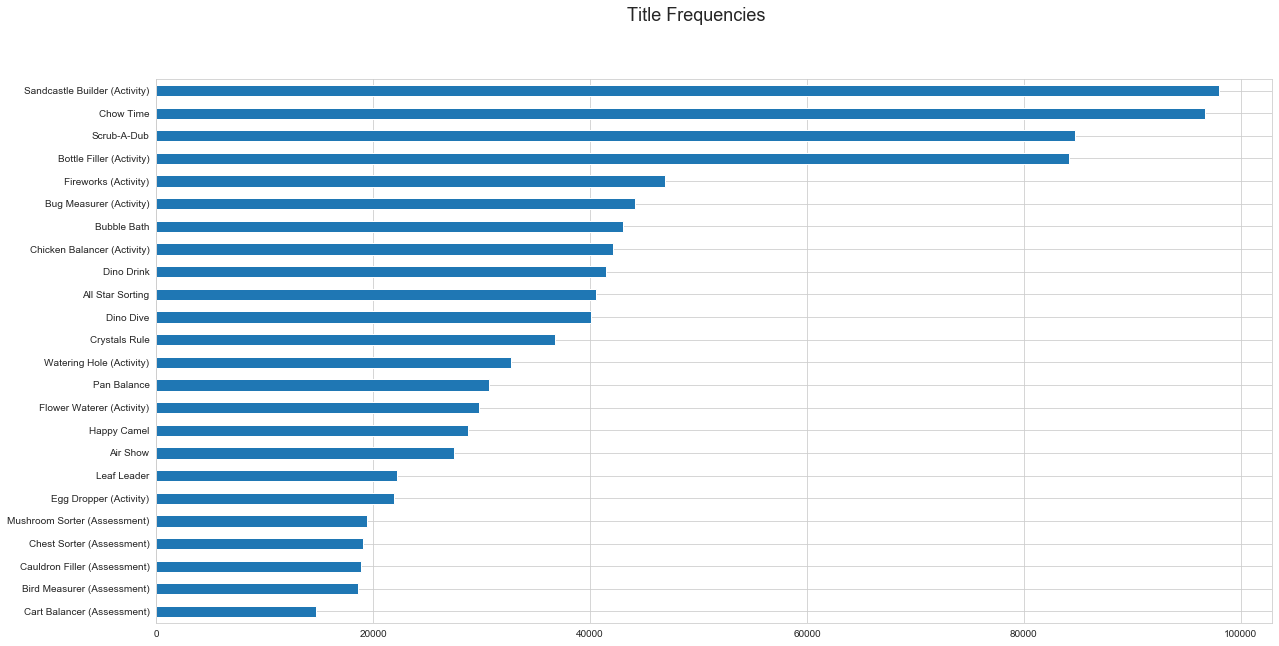

In [14]:
title_val_counts = train['title'].value_counts().sort_values()
_ = title_val_counts.plot(kind='barh',figsize=(20,10))
_ = plt.gcf().suptitle("Title Frequencies", size = 18)

In [15]:
pct_corrects = lambda g: round(g.sum()/g.count(),3)
assess_title = assessments.groupby(['title'])[['num_correct']]\
                          .agg(['count','sum', pct_corrects])

In [16]:
# Clean df
assess_title.columns = ['num_assessments', 'num_correct', 'pct_correct']
assess_title['pct_incorrect'] =  1 - assess_title.pct_correct
assess_title.index = [title.split('(')[0].strip() for title in assess_title.index]

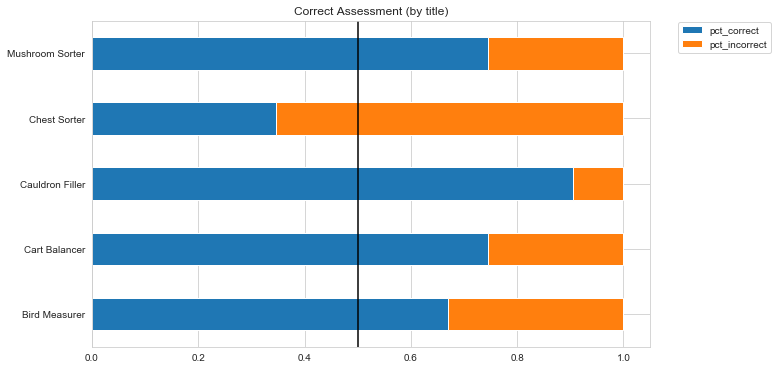

In [17]:
assess_title.loc[:,['pct_correct','pct_incorrect']]\
            .plot.barh(stacked=True,figsize=(10, 6), title='Correct Assessment (by title)')
plt.gca().legend(frameon=True,loc=(1.05,0.9))
plt.gca().axvline(x=0.5, ymin=0, ymax=1, color='black')

del assess_title

## <font color='green'> Good cols: ```'title'```</font> 

QUESTION: What pct of activities get completed and reach the assessment phase?

### 2) World

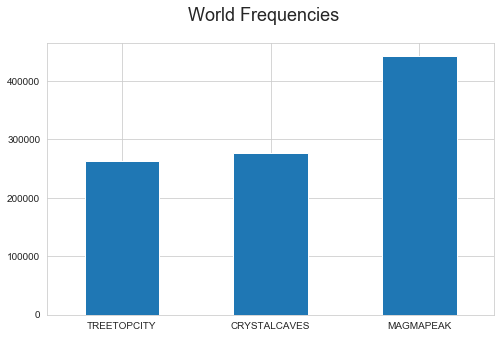

In [18]:
world_val_counts = train['world'].value_counts().sort_values()
_ = world_val_counts.plot(kind='bar',figsize=(8,5), color=my_pal[0])
_ = plt.gcf().suptitle("World Frequencies", size = 18)
ax = plt.gca()
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=0)

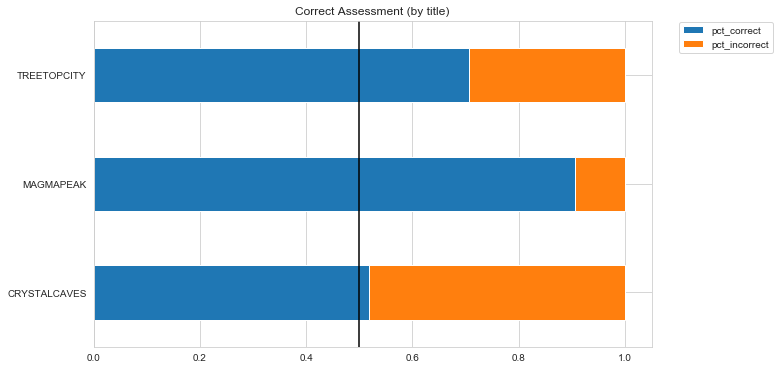

In [19]:
assess_world = assessments.groupby(['world'])[['num_correct']]\
                          .agg(['count','sum', pct_corrects])

# Clean df
assess_world.columns = ['num_assessments', 'num_correct', 'pct_correct']
assess_world['pct_incorrect'] =  1 - assess_world.pct_correct
assess_world.index = [title.split('(')[0].strip() for title in assess_world.index]

assess_world.loc[:,['pct_correct','pct_incorrect']]\
            .plot.barh(stacked=True,figsize=(10, 6), title='Correct Assessment (by title)')
plt.gca().legend(frameon=True,loc=(1.05,0.9))
plt.gca().axvline(x=0.5, ymin=0, ymax=1, color='black')

del assess_world

## <font color='green'> Good cols: ```'world'```  </font> 

### 3) Timestamps

In [20]:
def plot_assess_vs_timestamps(df, use_col):
    df = df.groupby(use_col)[['num_correct']]\
           .agg(['count','sum', pct_corrects])

    # Clean df
    df.columns = ['num_assessments', 'num_correct', 'pct_correct']
    df['pct_incorrect'] =  1 - df.pct_correct
    
    # Plot accuracies
    df.loc[:,['pct_correct','pct_incorrect']]\
                .plot.barh(stacked=True,figsize=(10, 6), title=f'Correct Assessment (by {use_col})')
    plt.gca().legend(frameon=True,loc=(1.05,0.9))
    plt.gca().axvline(x=0.5, ymin=0, ymax=1, color='black')
    
    
    return "STD of pct_correct for " + use_col + ": {:.2f}".format(df['pct_correct'].std())

In [21]:
assessments['hour'] = assessments['timestamp'].dt.hour
assessments['day'] = assessments['timestamp'].dt.day
assessments['weekday'] = assessments['timestamp'].dt.weekday
assessments['month'] = assessments['timestamp'].dt.month

'STD of pct_correct for day: 0.09'

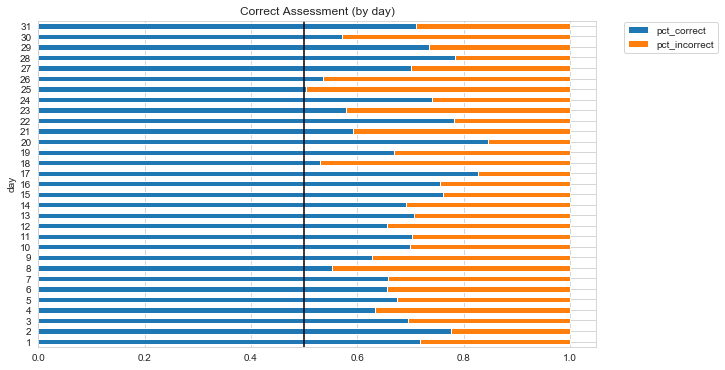

In [22]:
plot_assess_vs_timestamps(assessments, use_col='day')

The feature 'hour' has the highest STD (0.14) among: 'day' (0.09), 'weekday' (0.03), 'month' (0.03)

## <font color='green'> Good cols: ```'hour'``` and perhaps ```'day'``` </font> 
### <font color='green'> ADD New cols!</font> 

In [23]:
train['hour'] = train.timestamp.dt.hour
train['day'] = train.timestamp.dt.day

## 4) Type

In [24]:
for game_type in set(train.type):
    print(game_type)
    pprint(list(set(train[train.type==game_type].title)))

Activity
['Bottle Filler (Activity)',
 'Flower Waterer (Activity)',
 'Watering Hole (Activity)',
 'Egg Dropper (Activity)',
 'Fireworks (Activity)',
 'Bug Measurer (Activity)',
 'Sandcastle Builder (Activity)',
 'Chicken Balancer (Activity)']
Assessment
['Cart Balancer (Assessment)',
 'Bird Measurer (Assessment)',
 'Mushroom Sorter (Assessment)',
 'Chest Sorter (Assessment)',
 'Cauldron Filler (Assessment)']
Game
['Pan Balance',
 'All Star Sorting',
 'Scrub-A-Dub',
 'Bubble Bath',
 'Chow Time',
 'Happy Camel',
 'Dino Dive',
 'Air Show',
 'Leaf Leader',
 'Crystals Rule',
 'Dino Drink']


## <font color='red'>No new information in ```type```! <font>

## 5) Event_code 

In [25]:
print("Fraction of unique event codes: {0}/{1}"\
      .format(len(set(train.event_code)-set(assessments.event_code)),
              len(set(train.event_code)))
     )

Fraction of unique event codes: 20/42


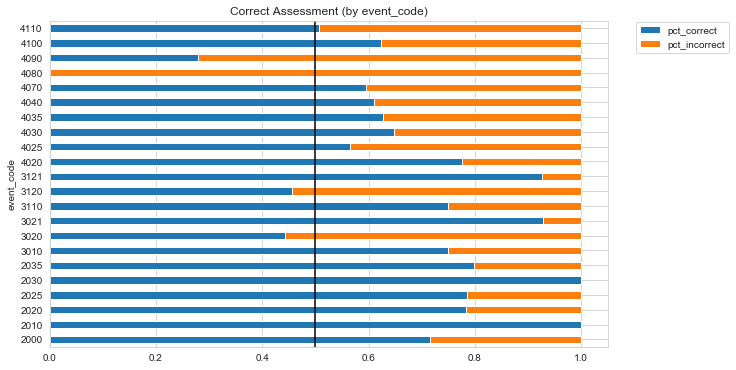

In [26]:
assess_ec = assessments.groupby(['event_code'])[['num_correct']]\
                          .agg(['count','sum', pct_corrects])

# Clean df
assess_ec.columns = ['num_assessments', 'num_correct', 'pct_correct']
assess_ec['pct_incorrect'] =  1 - assess_ec.pct_correct

assess_ec.loc[:,['pct_correct','pct_incorrect']]\
            .plot.barh(stacked=True,figsize=(10, 6), title='Correct Assessment (by event_code)')
plt.gca().legend(frameon=True,loc=(1.05,0.9))
plt.gca().axvline(x=0.5, ymin=0, ymax=1, color='black')

del assess_ec

## <font color='green'> Good cols: ```'event_code'``` - values in assessments!!! </font> 

## 6) Event_id

In [27]:
print("Fraction of unique Event IDs: {0}/{1}"\
      .format(len(set(train.event_id)-set(assessments.event_id)),
              len(set(train.event_id)))
     )

Fraction of unique Event IDs: 273/366


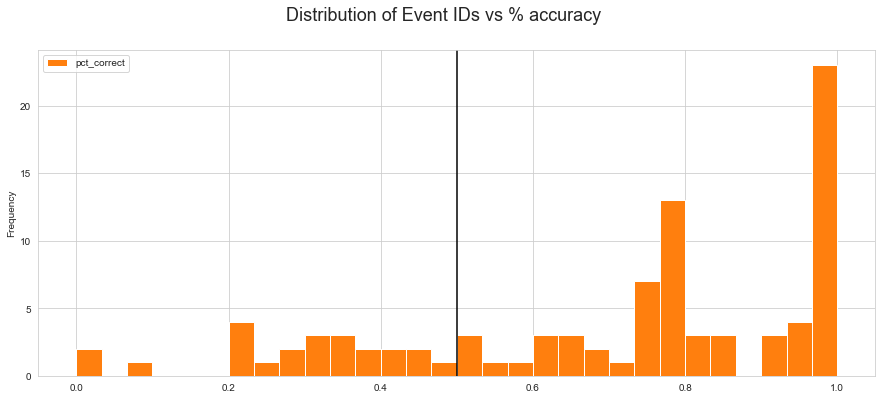

In [28]:
assess_ed = assessments.groupby('event_id')[['num_correct']]\
                       .agg(['count','sum', pct_corrects])

# Clean df
assess_ed.columns = ['num_assessments', 'num_correct', 'pct_correct']
assess_ed['pct_incorrect'] =  1 - assess_ed.pct_correct
assess_ed.index = [title.split('(')[0].strip() for title in assess_ed.index]

assess_ed.loc[:,['pct_correct']]\
         .plot(kind='hist' ,bins=30,edgecolor='white',
               figsize=(15,6),color=my_pal[1])

plt.gca().axvline(x=0.5, ymin=0, ymax=1, color='black')
plt.gcf().suptitle('Distribution of Event IDs vs % accuracy',fontsize = 18)


del assess_ed

## <font color='blue'>Continuous Data<font>

## 7) Game_session 

In [29]:
def no_unique_sessions(df, cut_off=1):
    
    return len(df[df.event_count>cut_off].reset_index()['game_session'].unique())
    

In [30]:
cut_off = 1
uniq_sess_assess = no_unique_sessions(assessments)
uniq_sess_train = no_unique_sessions(train, cut_off=cut_off)
pct_fraction = round(uniq_sess_assess/uniq_sess_train*100,2)

print(f"""Fraction of unique assessment sessions vs train(cut_off): {uniq_sess_assess}/{uniq_sess_train} = {pct_fraction}%""")


Fraction of unique assessment sessions vs train(cut_off): 1798/10994 = 16.35%


## 8) Game_time

In [31]:
assessments.groupby(['installation_id','title'])[['game_time']].sum().unstack()[:10]

game_time                                                                                                               
title           Bird Measurer (Assessment) Cart Balancer (Assessment) Cauldron Filler (Assessment) Chest Sorter (Assessment) Mushroom Sorter (Assessment)
installation_id                                                                                                                                          
435871                               78.52                        NaN                          NaN                       NaN                        28.77
442770                              366.12                        NaN                         3.10                       NaN                        82.30
1218646                              13.40                        NaN                          NaN                       NaN                          NaN
1904336                              25.14                       2.09                          NaN                      8.53                        31.48
2252647                               8.40                        NaN                          NaN                       NaN                          NaN
2595525                                NaN                        NaN                          NaN                    199.90                          NaN
2996195                             143.47                      11.62                         7.70                     62.32                        24.65
3371696                              16.20                      14.04                        10.81                     32.10                         8.95
4989073                               5.23                        NaN                        13.38                       NaN                          NaN
6505523                                NaN                       6.76                        33.82                     49.94                          NaN

## 9) Event_count

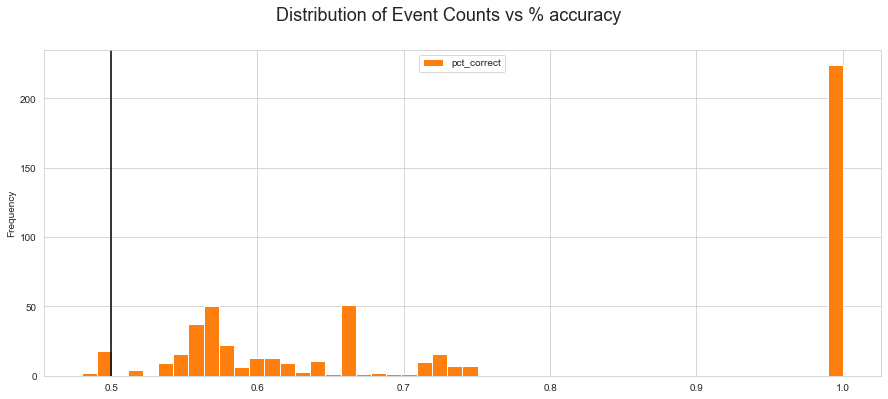

In [32]:
assess_ec = assessments.groupby('event_count')[['num_correct']]\
                       .agg(['count','sum', pct_corrects])

# Clean df
assess_ec.columns = ['num_assessments', 'num_correct', 'pct_correct']
assess_ec['pct_incorrect'] =  1 - assess_ec.pct_correct

assess_ec.loc[:,['pct_correct']]\
         .plot(kind='hist' ,bins=50,edgecolor='white',
               figsize=(15,6),color=my_pal[1])

plt.gca().axvline(x=0.5, ymin=0, ymax=1, color='black')
plt.gcf().suptitle('Distribution of Event Counts vs % accuracy',fontsize = 18)


del assess_ec

## <font color='blue'>Meta-Data<font>

## 10) Event_data

In [33]:
for d in assessments.event_data.values[:10]:
    print(d)

{'version': '1.0', 'event_count': 1, 'game_time': 0, 'event_code': 2000}
{'event_count': 2, 'game_time': 77, 'event_code': 2025}
{'description': 'Pull three mushrooms out of the ground and order them from shortest to tallest!', 'identifier': 'Dot_PullMushrooms', 'media_type': 'audio', 'total_duration': 3000, 'event_count': 3, 'game_time': 77, 'event_code': 3010}
{'coordinates': {'x': 199, 'y': 484, 'stage_width': 1015, 'stage_height': 762}, 'event_count': 4, 'game_time': 2784, 'event_code': 4070}
{'height': 1, 'coordinates': {'x': 171, 'y': 519, 'stage_width': 1015, 'stage_height': 762}, 'event_count': 5, 'game_time': 3625, 'event_code': 4025}
{'description': 'Pull three mushrooms out of the ground and order them from shortest to tallest!', 'identifier': 'Dot_PullMushrooms', 'media_type': 'audio', 'duration': 3548, 'event_count': 6, 'game_time': 3625, 'event_code': 3110}
{'description': "That's one!", 'identifier': 'Dot_ThatsOne', 'media_type': 'audio', 'total_duration': 600, 'event_co

# C. Feature Engineering

Let's first try to construct "domain-like" features which might correlate to user performance. Intuitively, I'll seek for features that somehow describe:

1. Level of game difficulty
2. User Expertise
3. User Focus 
4. Clarity of Game Instructions
5. Other

In particular, I'll use the continuous cols to construct aggregated feats.

## QUESTION: What pct of activities get completed and reach the assessment phase?

## C1. Game_time Aggregations
How much time do the app users spend:<br>
a) playing in general <br>
b) playing in a certain level (title) <br>
c) playing in a certain world <br>
d) on average per game session <br>
e) to complete a particular task <br>

### a) Net Game Time

In [34]:
def net_time(df):
    
    return df.groupby('installation_id')[['game_time']]\
             .sum()\
             .rename({'game_time': 'net_time'}, axis=1)

In [35]:
net_times = net_time(train)

In [36]:
net_times.head()

,net_time
installation_id,
125199,4563.90
280516,244.44
435871,5225.76
442770,3350.47
632233,2736.90


In [37]:
print('Number of ids with ZERO net_time : {0}/{1}'
      .format(np.sum(net_times['net_time']==0), 
              len(net_times))
     )
     

Number of ids with ZERO net_time : 2/1119


In [38]:
less_than = 1
print('Number of ids with net_time less than {0} min: {1}/{2}'
      .format(less_than, 
              np.sum(net_times['net_time']<less_than), 
              len(net_times))
     )

Number of ids with net_time less than 1 min: 22/1119


In [39]:
def plot_log_distribution(df, cut_off=1, title="Distribution of Log(net_time) with cut-off="):
   
    # filter out ids with net_time less than threshold (min)
    df = df[df.net_time > cut_off]
    df.apply(np.log)\
      .plot(kind='hist' ,bins=50,edgecolor='white',
            figsize=(15,6),color=my_pal[1])
    plt.gcf().suptitle(title+str(cut_off),fontsize = 18)
    plt.ylabel('num_ids', fontsize=18)
    
    return df.describe()
    

,net_time
count,1096.000000
mean,2456.108823
std,7321.960625
min,1.030000
25%,106.110000
50%,475.130000
75%,1748.597500
max,107002.490000


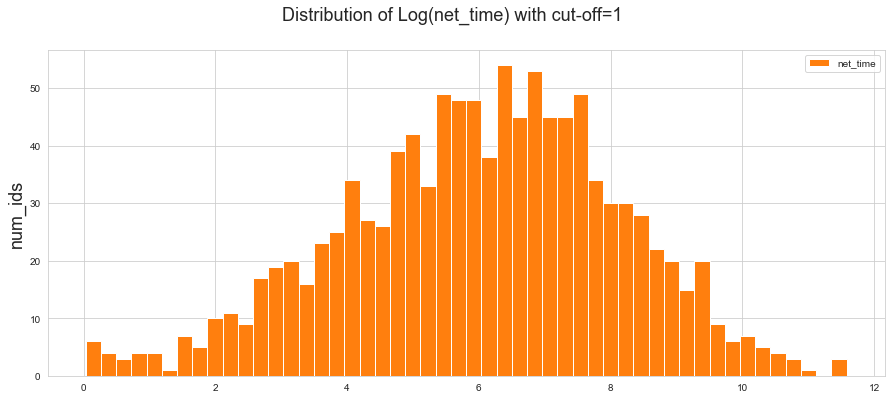

In [40]:
plot_log_distribution(net_times)

## <font color='green'> Good Features: ```net_time``` </font> 

Comments: 
- perhaps use log of net_time 
- treat differently ids with zero to less than a cut_off-value of game time


### b) Game Times Per Title

In [41]:
def plot_barh_chart(df ,col):
    
    df = df.groupby(col)['game_time']\
           .sum()\
           .sort_values()
    
    df.plot(kind='barh',figsize=(10,6))
    plt.gcf().suptitle("Net Game Time Per " + col.title(), size = 18)
    plt.gca().set_ylabel(plt.gca().get_ylabel(), visible=False) #remove ylabel
    
    return df.describe()

count        24.000000
mean     112162.643750
std      109094.089271
min        7983.320000
25%       49515.712500
50%       77829.115000
75%      139781.872500
max      435304.750000
Name: game_time, dtype: float64

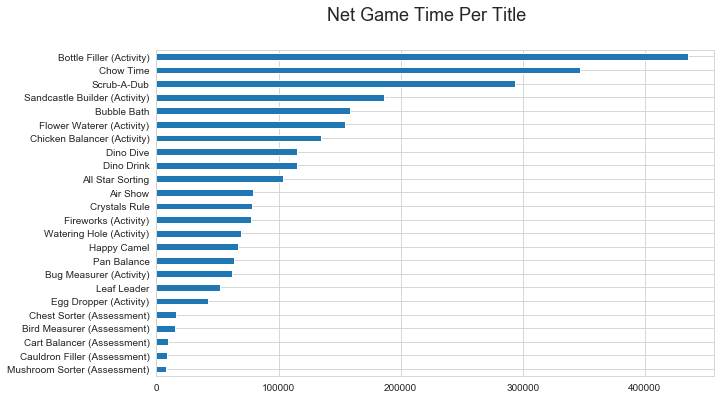

In [42]:
plot_barh_chart(train, col='title')

In [43]:
def net_times_per_col(df, col):
    
    return train.groupby(['installation_id', col])[['game_time']]\
                .sum()\
                .rename({'game_time': 'net_time_per_' + col}, axis=1)\
                .unstack()\
                .fillna(0)

In [44]:
net_times_per_col(train, col='title').head()

net_time_per_title                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
title                     Air Show All Star Sorting Bird Measurer (Assessment) Bottle Filler (Activity) Bubble Bath Bug Measurer (Activity) Cart Balancer (Assessment) Cauldron Filler (Assessment) Chest Sorter (Assessment) Chicken Balancer (Activity) Chow Time Crystals Rule Dino Dive Dino Drink Egg Dropper (Activity) Fireworks (Activity) Flower Waterer (Activity) Happy Camel Leaf Leader Mushroom Sorter (Assessment) Pan Balance Sandcastle Builder (Activity) Scrub-A-Dub Watering Hole (Activity)
installation_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
125199                        0.00              0.0                       0.00                     0.00        0.00                    0.00                        0.0                         0.00                       0.0                        0.00      0.00          0.00      0.00     304.14                    0.0                 0.00                      0.00         0.0         0.0                         0.00        0.00                        495.39     3764.37                     0.00
280516                        0.00              0.0                       0.00                     0.00        0.00                    0.00                        0.0                         0.00                       0.0                        0.00      0.00          0.00      0.00     193.02                    0.0                 0.00                      0.00         0.0         0.0                         0.00        0.00                          0.00        0.00                    51.42
435871                      479.98            124.6                      78.52                   622.83      340.05                  270.66                        0.0                         0.00                       0.0                        0.00      0.00        381.35     20.70     301.65                    0.0              1495.52                    339.12         0.0         0.0                        29.74        0.00                        261.13      378.24                   101.67
442770                        0.00              0.0                     366.12                   843.68      137.03                  104.85                        0.0                         3.12                       0.0                      103.87     51.25          0.77    238.11       0.00                    0.0                 0.00                    452.06         0.0         0.0                        82.30        1.23                        586.18      371.76                     8.14
632233                        0.00              0.0                       0.00                     0.00        0.00                    0.00                        0.0                         0.00                       0.0                        0.00      0.00          0.00   2571.03       0.00                    0.0                 0.00                      0.00         0.0         0.0                         0.00        0.00                        115.61        0.00                    50.26

## <font color='green'>  Good Features:  ```net_time_per_title```<font>

### c) Game Time per World

count    3.000000e+00
mean     8.973012e+05
std      4.259774e+05
min      5.787693e+05
25%      6.553723e+05
50%      7.319752e+05
75%      1.056567e+06
max      1.381159e+06
Name: game_time, dtype: float64

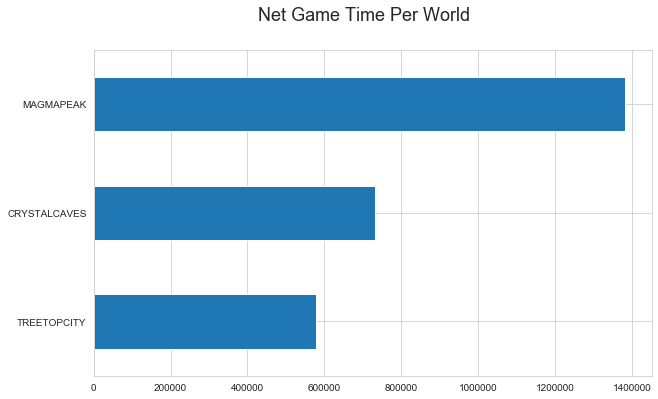

In [45]:
plot_barh_chart(train, col='world')

In [46]:
net_times_per_col(train, col='world').head()

net_time_per_world                      
world                 CRYSTALCAVES MAGMAPEAK TREETOPCITY
installation_id                                         
125199                        0.00   4563.90        0.00
280516                        0.00    244.44        0.00
435871                        0.00   2026.27     3199.49
442770                      156.35   2188.02     1006.10
632233                        0.00   2736.90        0.00

## <font color='green'>  Good Features:  ```net_time_per_world```<font>

COMMENT: Can also compute aggregates for event_counts, game_sessions, etc per title/world

### d) Avg Time Per Session

In [47]:
def avg_time_per_sess(df):
    
    df = df.reset_index()\
           .groupby(['installation_id'])[['game_time','game_session']]\
           .agg({'game_time': 'sum',
                 'game_session': 'nunique'})
    
    df['avg_time_per_sess'] = df['game_time'] / df['game_session']
    
    return df[['avg_time_per_sess']].astype('int')

             

In [48]:
avg_time_per_sess(train).head()

,avg_time_per_sess
installation_id,
125199,912
280516,122
435871,124
442770,186
632233,912


### e)  Time per task (Activity)

In [49]:
train[train.type=="Activity"].head()

event_id                        timestamp                                         event_data  event_count  event_code  game_time                          title      type      world  hour  day
installation_id game_session                                                                                                                                                                                                     
125199          0848ef14a8dc6892  77261ab5 2019-09-06 17:54:56.302000+00:00  {'version': '1.0', 'event_count': 1, 'game_tim...            1        2000       0.00  Sandcastle Builder (Activity)  Activity  MAGMAPEAK    17    6
                0848ef14a8dc6892  b2dba42b 2019-09-06 17:54:56.387000+00:00  {'description': 'Let's build a sandcastle! Fir...            2        3010       0.00  Sandcastle Builder (Activity)  Activity  MAGMAPEAK    17    6
                0848ef14a8dc6892  1bb5fbdb 2019-09-06 17:55:03.253000+00:00  {'description': 'Let's build a sandcastle! Fir...            3        3110       0.12  Sandcastle Builder (Activity)  Activity  MAGMAPEAK    17    6
                0848ef14a8dc6892  1325467d 2019-09-06 17:55:06.279000+00:00  {'coordinates': {'x': 583, 'y': 605, 'stage_wi...            4        4070       0.17  Sandcastle Builder (Activity)  Activity  MAGMAPEAK    17    6
                0848ef14a8dc6892  1325467d 2019-09-06 17:55:06.913000+00:00  {'coordinates': {'x': 601, 'y': 570, 'stage_wi...            5        4070       0.18  Sandcastle Builder (Activity)  Activity  MAGMAPEAK    17    6

## C2. Game_session Aggregations

### a) Count Sessions Per Col

In [50]:
def count_sess_per_col(df, col):
    
    return df.reset_index()\
             .groupby(['installation_id', col])[['game_session']]\
             .nunique()\
             .rename({'game_session': 'no_sess_per_' + col}, axis=1)\
             .unstack()\
             .fillna(0)
    


In [51]:
count_sess_per_col(train, col='hour').head()

no_sess_per_hour                                                                                                                     
hour                          0    1    2    3    4     5    6    7    8    9    10   11   12   13   14    15   16   17   18   19   20   21   22   23
installation_id                                                                                                                                      
125199                       0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  2.0  3.0  0.0  0.0  0.0  0.0  0.0
280516                       0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
435871                       0.0  0.0  0.0  0.0  1.0  18.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  8.0  2.0  6.0  0.0  8.0  0.0  0.0  0.0
442770                       6.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
632233                       0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  3.0  1.0  0.0  0.0  0.0  0.0

In [52]:
count_sess_per_col(train, col='day').head()

no_sess_per_day                                                                                                                                                        
day                          1    2    3    4    5     6    7    8    9    10   11   12   13    14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31
installation_id                                                                                                                                                                        
125199                      0.0  0.0  0.0  0.0  0.0   5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
280516                      0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
435871                      0.0  0.0  0.0  0.0  0.0  29.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  8.0  0.0  0.0
442770                      4.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  10.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
632233                      0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [53]:
count_sess_per_col(train, col='world').head()

no_sess_per_world                      
world                CRYSTALCAVES MAGMAPEAK TREETOPCITY
installation_id                                        
125199                        0.0       5.0         0.0
280516                        0.0       2.0         0.0
435871                        0.0      22.0        20.0
442770                        3.0      10.0         5.0
632233                        0.0       3.0         0.0

In [54]:
count_sess_per_col(train, col='title').head()

no_sess_per_title                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
title                    Air Show All Star Sorting Bird Measurer (Assessment) Bottle Filler (Activity) Bubble Bath Bug Measurer (Activity) Cart Balancer (Assessment) Cauldron Filler (Assessment) Chest Sorter (Assessment) Chicken Balancer (Activity) Chow Time Crystals Rule Dino Dive Dino Drink Egg Dropper (Activity) Fireworks (Activity) Flower Waterer (Activity) Happy Camel Leaf Leader Mushroom Sorter (Assessment) Pan Balance Sandcastle Builder (Activity) Scrub-A-Dub Watering Hole (Activity)
installation_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
125199                        0.0              0.0                        0.0                      0.0         0.0                     0.0                        0.0                          0.0                       0.0                         0.0       0.0           0.0       0.0        1.0                    0.0                  0.0                       0.0         0.0         0.0                          0.0         0.0                           3.0         1.0                      0.0
280516                        0.0              0.0                        0.0                      0.0         0.0                     0.0                        0.0                          0.0                       0.0                         0.0       0.0           0.0       0.0        1.0                    0.0                  0.0                       0.0         0.0         0.0                          0.0         0.0                           0.0         0.0                      1.0
435871                        2.0              4.0                        2.0                      2.0         2.0                     2.0                        0.0                          0.0                       0.0                         0.0       0.0           2.0       2.0        3.0                    0.0                  2.0                       2.0         0.0         0.0                          4.0         0.0                           6.0         4.0                      3.0
442770                        0.0              0.0                        1.0                      1.0         1.0                     1.0                        0.0                          2.0                       0.0                         1.0       1.0           1.0       1.0        0.0                    0.0                  0.0                       1.0         0.0         0.0                          1.0         1.0                           3.0         1.0                      1.0
632233                        0.0              0.0                        0.0                      0.0         0.0                     0.0                        0.0                          0.0                       0.0                         0.0       0.0           0.0       1.0        0.0                    0.0                  0.0                       0.0         0.0         0.0                          0.0         0.0                           1.0         0.0                      1.0

## <font color='green'>  Good Features:  ```no_sess_per_col```<font>
```col = ['hour', 'day', 'title', 'world']```

### b) 

## <font color='green'>  Good Features:  ```time_per_sess, events_per_sess, avg_time_per_sess```<font>

### c) How often do they sign in AND play? And Why?

## C3. Event_code Aggregations

In [55]:
def count_codes_per_col(df, col):
    
    return df.reset_index()\
             .groupby(['installation_id', col])[['event_code']]\
             .nunique()\
             .rename({'event_code': 'no_codes_per_' + col}, axis=1)\
             .unstack()\
             .fillna(0)

In [56]:
count_codes_per_col(train, 'world').head()

no_codes_per_world                      
world                 CRYSTALCAVES MAGMAPEAK TREETOPCITY
installation_id                                         
125199                         0.0      23.0         0.0
280516                         0.0      19.0         0.0
435871                         0.0      36.0        26.0
442770                        16.0      32.0        22.0
632233                         0.0      21.0         0.0

In [57]:
count_codes_per_col(train, 'title').head()

no_codes_per_title                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
title                     Air Show All Star Sorting Bird Measurer (Assessment) Bottle Filler (Activity) Bubble Bath Bug Measurer (Activity) Cart Balancer (Assessment) Cauldron Filler (Assessment) Chest Sorter (Assessment) Chicken Balancer (Activity) Chow Time Crystals Rule Dino Dive Dino Drink Egg Dropper (Activity) Fireworks (Activity) Flower Waterer (Activity) Happy Camel Leaf Leader Mushroom Sorter (Assessment) Pan Balance Sandcastle Builder (Activity) Scrub-A-Dub Watering Hole (Activity)
installation_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
125199                         0.0              0.0                        0.0                      0.0         0.0                     0.0                        0.0                          0.0                       0.0                         0.0       0.0           0.0       0.0       16.0                    0.0                  0.0                       0.0         0.0         0.0                          0.0         0.0                           9.0        16.0                      0.0
280516                         0.0              0.0                        0.0                      0.0         0.0                     0.0                        0.0                          0.0                       0.0                         0.0       0.0           0.0       0.0       14.0                    0.0                  0.0                       0.0         0.0         0.0                          0.0         0.0                           0.0         0.0                     10.0
435871                        17.0             16.0                       16.0                      9.0        22.0                     7.0                        0.0                          0.0                       0.0                         0.0       0.0          12.0       6.0       17.0                    0.0                  6.0                       8.0         0.0         0.0                         18.0         0.0                           9.0        17.0                      9.0
442770                         0.0              0.0                       18.0                      9.0        20.0                     7.0                        0.0                         11.0                       0.0                         9.0      14.0           4.0      14.0        0.0                    0.0                  0.0                       8.0         0.0         0.0                         16.0         4.0                           9.0        17.0                      4.0
632233                         0.0              0.0                        0.0                      0.0         0.0                     0.0                        0.0                          0.0                       0.0                         0.0       0.0           0.0      15.0        0.0                    0.0                  0.0                       0.0         0.0         0.0                          0.0         0.0                           8.0         0.0                      9.0

In [58]:
count_codes_per_col(train, 'hour').head()

no_codes_per_hour                                                                                                                            
hour                           0     1    2    3    4     5    6    7    8    9    10   11   12    13    14    15    16    17    18   19    20   21   22   23
installation_id                                                                                                                                              
125199                        0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   9.0  22.0  0.0   0.0  0.0  0.0  0.0
280516                        0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  10.0  14.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0
435871                        0.0   0.0  0.0  0.0  8.0  37.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  34.0  11.0  26.0  0.0  25.0  0.0  0.0  0.0
442770                       23.0  11.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  11.0   0.0  33.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0
632233                        0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0  20.0  9.0   0.0  0.0  0.0  0.0

## 4. Clarity of game instructions

Game Clarity:<br>
a) rate hints based on user performance <br>
b) check if the user was doing something weird: from coords (e.g. false negatives) <br>
c) check if the user was doing something weird to familiarize himself/herself with the game (e.g. at the beginnig might press randomly)